In [1]:
from time import time
start_time = time()

### Imports, Load Data and inspect

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
import spopt
from spopt.region import WardSpatial
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import libpysal as ps
import esda
import math
import contextily as ctx

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# BIG DATASET
# Split 1
#pth = r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-train1-voro1.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-test1.shp"

# Split 2
#pth = r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-train2-voro2.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-test2.shp"

# Split 3
#pth = r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-train3-voro3.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-test3.shp"

# SMALL DATASET
# Split 1
pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-1_voro.shp"
test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-1_points.shp"

# Split 2
#pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-2_voro.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-2_points.shp"

# Split 3
#pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-3_voro.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-3_points.shp"


houses = gpd.read_file(pth)

In [5]:
houses.head(2)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -..."
1,96200.0,1.6007,21.0,1327.0,488.0,3.645492,0.954918,"POLYGON ((275235.497 -599843.782, 273503.882 -..."


In [6]:
houses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MedHouseVa  1640 non-null   float64 
 1   MedIncome   1640 non-null   float64 
 2   MedianAge   1640 non-null   float64 
 3   Population  1640 non-null   float64 
 4   Households  1640 non-null   float64 
 5   roomsperHH  1640 non-null   float64 
 6   bedroomHH   1640 non-null   float64 
 7   geometry    1640 non-null   geometry
dtypes: float64(7), geometry(1)
memory usage: 102.6 KB


### WARD Regionalization

In [7]:
houses.shape

(1640, 8)

In [8]:
attribute_name = ['MedHouseVa']

In [9]:
wq = Queen.from_dataframe(houses)
wq.n

C:\Users\lukasb97\AppData\Local\Temp\ipykernel_17604\266690351.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(houses)


1640

In [10]:
n_clusters = 23

In [11]:
%%time
model = WardSpatial(houses, wq, attribute_name, n_clusters)
model.solve()

CPU times: total: 62.5 ms
Wall time: 57.1 ms


In [12]:
column_name = f'ward_{n_clusters}'

In [13]:
houses[column_name] = model.labels_

<Axes: >

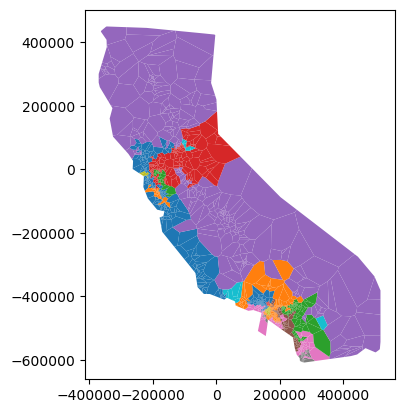

In [14]:
houses.plot(column=column_name, categorical=True)

### Choose best model, then only keep necessary columns

In [15]:
houses.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,ward_23
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",16


In [16]:
keepcolumns = ['MedHouseVa', 'MedIncome', 'MedianAge', 'Population', 'Households', 'roomsperHH', 'bedroomHH', 'geometry', 
               column_name]
houses = houses.loc[:, keepcolumns]
houses.head()

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,ward_23
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",16
1,96200.0,1.6007,21.0,1327.0,488.0,3.645492,0.954918,"POLYGON ((275235.497 -599843.782, 273503.882 -...",16
2,125000.0,1.7301,5.0,3148.0,855.0,3.164912,1.081871,"POLYGON ((276137.045 -604431.281, 275994.245 -...",16
3,139500.0,3.6736,23.0,1371.0,327.0,5.556575,0.987768,"POLYGON ((269191.311 -606347.166, 269183.834 -...",16
4,139300.0,3.8615,26.0,1145.0,313.0,4.993610,0.913738,"POLYGON ((279114.859 -598990.282, 278765.629 -...",16


## Spatial join the test data

In [17]:
test_p = gpd.read_file(test_p_pth)

In [18]:
test_p.head(2)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796)
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957)


In [19]:
test_p.shape

(411, 8)

<Axes: >

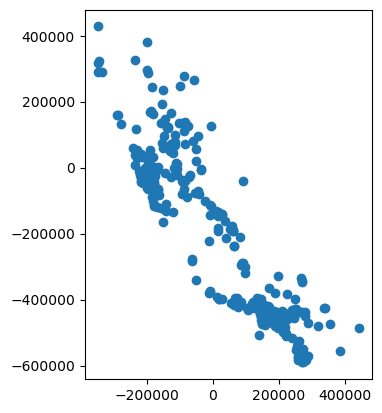

In [20]:
test_p.plot()

In [21]:
# temporary copy so just the columns wanted are used in the join
temp_train_gdf = houses[[column_name, 'geometry']].copy()

joined_gdf = gpd.sjoin(test_p, temp_train_gdf, how="left", op="within")
joined_gdf = joined_gdf.drop(columns=['index_right'])

# --> provides test data with cluster number

C:\Users\lukasb97\.conda\envs\test\Lib\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [22]:
houses.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,ward_23
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",16


In [23]:
joined_gdf.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,ward_23
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),9


<Axes: >

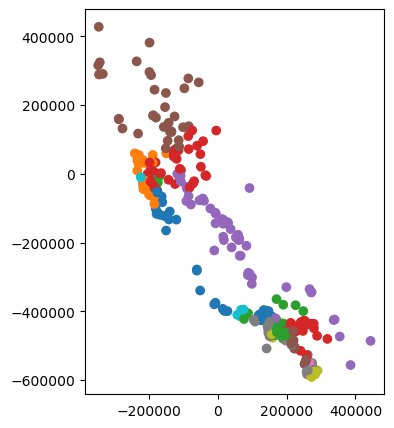

In [24]:
joined_gdf.plot(column=column_name, categorical=True, figsize=(5,5), )

## Variable Definitions for RF models

In [25]:
y_train = houses['MedHouseVa']
y_test = joined_gdf['MedHouseVa']

X_train = houses.drop(["MedHouseVa", "geometry"], axis=1)
X_test = joined_gdf.drop(["MedHouseVa", "geometry"], axis=1)

In [26]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1640, 7)
Training Labels Shape: (1640,)
Testing Features Shape: (411, 7)
Testing Labels Shape: (411,)


In [27]:
# Define labels and weights for loop - change depending on which model get used
region_labels = houses[column_name].values
region_labels_test = joined_gdf[column_name].values
weights = [len(y_train[region_labels == i]) for i in range(len(np.unique(region_labels)))]

In [28]:
param_dist = {
    'n_estimators': np.arange(50, 210, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 12),
    'min_samples_leaf': np.arange(1, 5),
    'bootstrap': [True, False]
}

In [29]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

## RegRF_CN with Region Number as additional independent variable + HPO

In [30]:
%%time
#start_time = time()
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
CPU times: total: 1.62 s
Wall time: 5.76 s


In [31]:
%%time
hpo_rf = RandomForestRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
hpo_rf.fit(X_train, y_train)
predictions = hpo_rf.predict(X_test)

CPU times: total: 2.12 s
Wall time: 124 ms


In [32]:
# Calculate Evaluation Metrics
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'units.')
r2 = round(r2_score(y_test, predictions), 3)
print("R2: ", r2)
mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))
#print("Time for RegRF_CN: {:.2f} seconds".format(time() - start_time))

Mean Absolute Error: 42677.5 units.
R2:  0.749
MSE:  3352245114.6784763
RMSE:  57898.57610234017


### LISA

In [33]:
test_p['predictions'] = predictions.flatten()
test_p['y_test'] = y_test
test_p['test_res'] = test_p['y_test'] - test_p['predictions']

print(test_p.shape)
test_p.head(1)

(411, 11)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),74205.119048,55000.0,-19205.119048


<Axes: >

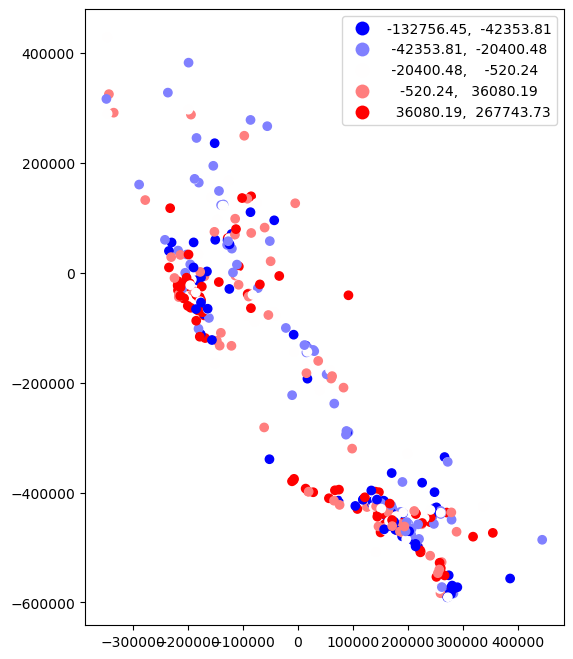

In [34]:
# plot residuals
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

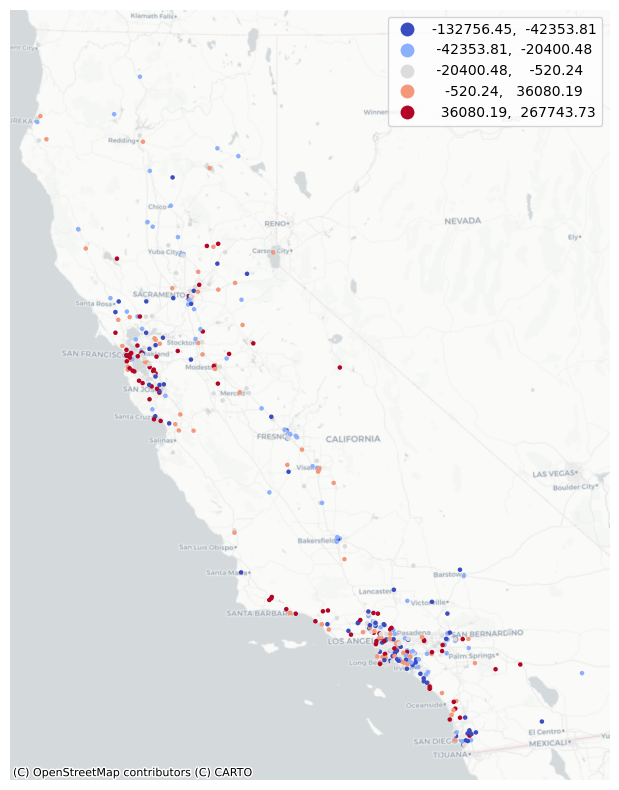

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='coolwarm', legend=True, ax=ax, markersize=5)
ctx.add_basemap(ax, crs=test_p.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/basemap_WARD.png'
#plt.savefig(save_path)
plt.show()

In [36]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=7) 
wi.transform = 'r'
y = test_p['test_res']

In [37]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.129 and p-value is 0.000999000999000999 expected value is -0.0024390243902439024


In [38]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [39]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
test_p.head(2)

group
not-significant    336
coldspot            30
hotspot             28
cold outlier        11
hot outlier          6
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_17604\894966211.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),74205.119048,55000.0,-19205.119048,0.166256,0.068,not-significant
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),92683.003663,104200.0,11516.996337,-0.033387,0.373,not-significant


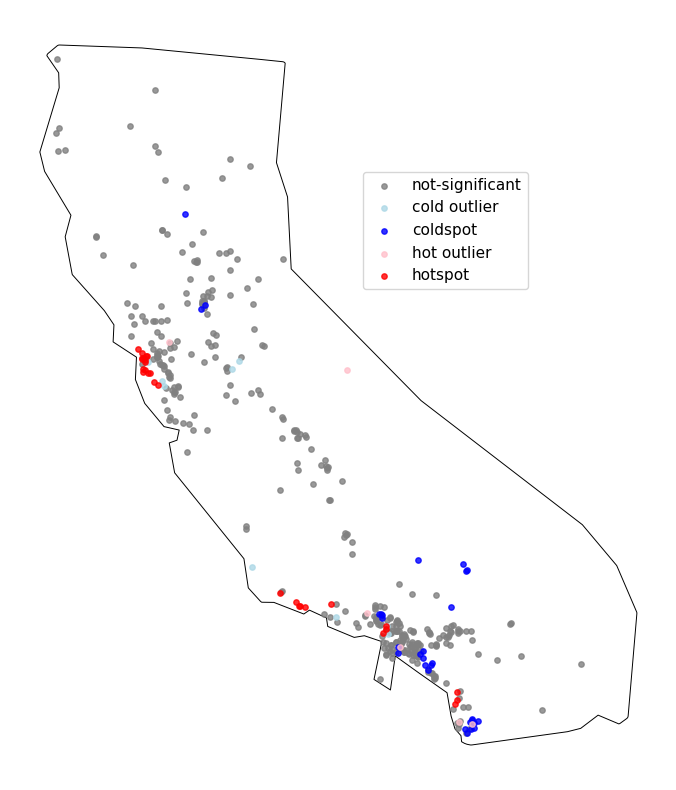

In [40]:
state_boundary = gpd.read_file(r"Y:/Lukas/thesis/bus1123/bufferedcliprahmen.shp")
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}

state_boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, facecolor='none')

for ctype, data in test_p.groupby('group'):
    if ctype == 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

for ctype, data in test_p.groupby('group'):
    if ctype != 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

ax.legend(bbox_to_anchor=(0.8, .8), prop={'size': 11})

ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/lisa_ward_S2_big.png'
#plt.savefig(save_path)
plt.show()

## RegRF_SEP - Separate RF for each Region  - was omitted in the process (might not run, depening on regionalization)

In [ ]:
'''
predictions_list = []
y_test_list = []
residuals_list = []
all_r2 = []
all_mae = []
all_mse = []
all_rmse = []

for i in range(len(np.unique(region_labels))):
    X_region_train = X_train[region_labels == i]
    y_region_train = y_train[region_labels == i]
    X_region_test = X_test[region_labels_test == i]
    y_region_test = y_test[region_labels_test == i]

    rf.fit(X_region_train, y_region_train)

    y_pred = rf.predict(X_region_test)

    # Save results so they can all be analysed together
    predictions_list.extend(y_pred)
    y_test_list.extend(y_region_test)
    residuals_list.extend(y_region_test - y_pred)

    # Same for performance
    r2 = r2_score(y_region_test, y_pred)
    mae = mean_absolute_error(y_region_test, y_pred)
    mse = mean_squared_error(y_region_test, y_pred)
    rmse = np.sqrt(mse)

    all_r2.append(r2)
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)

    print(f'Region {i} - R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}')

# Calculate average errors
avg_r2 = np.mean(all_r2)
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f'\nAverage R2: {avg_r2:.3f}, Average MAE: {avg_mae:.3f}, Average MSE: {avg_mse:.3f}, Average RMSE: {avg_rmse:.3f}')
'''

### LISA

In [ ]:
test_p['predictions'] = predictions_list
test_p['y_test'] = y_test_list
test_p['test_res'] = residuals_list

print(test_p.shape)
test_p.head(1)

In [ ]:
# plot residuals
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [ ]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=5) 
wi.transform = 'r'
y = test_p['test_res']

In [ ]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

In [ ]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [ ]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
test_p.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in test_p.groupby('group'):
    
    color = group_colors[ctype]
    
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()

## RegRF_W - Multitple Global RFs with more weight on the specific regions

In [ ]:
%%time
models = []
all_r2 = []
all_mae = []
all_mse = []

param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),
}

for i in range(len(np.unique(region_labels))):
    region_rf_model = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(region_rf_model, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train, sample_weight=np.where(region_labels == i, weights[i], 1))
    best_params = random_search.best_params_

    rf_randhpo = RandomForestRegressor(random_state=42, **best_params)
    rf_randhpo.fit(X_train, y_train, sample_weight=np.where(region_labels == i, weights[i], 1))
    models.append(rf_randhpo)

    y_pred = rf_randhpo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    all_r2.append(r2)
    all_mae.append(mae)
    all_mse.append(mse)

    print(f'Region {i} - R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}, Best Hyperparameters: {best_params}')

avg_r2 = np.mean(all_r2)
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)

print(f'\nAverage R2: {avg_r2:.3f}, Average MAE: {avg_mae:.3f}, Average MSE: {avg_mse:.3f}')

In [41]:
%%time
test_p['residuals'] = 0
all_residuals = []
all_r2 = []
all_mae = []
all_mse = []
all_rmse = []

# Loop over regions
for i in range(len(np.unique(region_labels))):
    rf_randhpo = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_randhpo.fit(X_train, y_train, sample_weight=np.where(region_labels == i, weights[i], 1))
    
    y_pred = rf_randhpo.predict(X_test)

    residuals = y_test - y_pred

    all_residuals.append(residuals)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    all_r2.append(r2)
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)

    print(f'Region {i} - R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}')

all_residuals_array = np.array(all_residuals)

average_residuals = np.mean(all_residuals_array, axis=0)

test_p['residuals'] = average_residuals

avg_r2 = np.mean(all_r2)
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f'\nAverage R2: {avg_r2:.3f}, Average MAE: {avg_mae:.3f}, Average MSE: {avg_mse:.3f}, Average RMSE: {avg_rmse:.3f}')

Region 0 - R2: 0.729, MAE: 44582.243, MSE: 3611890116.118, RMSE: 60099.003
Region 1 - R2: 0.744, MAE: 42318.783, MSE: 3410160960.107, RMSE: 58396.583
Region 2 - R2: 0.751, MAE: 42017.615, MSE: 3321802329.586, RMSE: 57635.079
Region 3 - R2: 0.746, MAE: 42148.101, MSE: 3380277192.018, RMSE: 58140.151
Region 4 - R2: 0.720, MAE: 44622.031, MSE: 3736960392.305, RMSE: 61130.683
Region 5 - R2: 0.738, MAE: 42884.060, MSE: 3494707957.538, RMSE: 59116.055
Region 6 - R2: 0.745, MAE: 42708.480, MSE: 3402341830.551, RMSE: 58329.597
Region 7 - R2: 0.708, MAE: 46160.669, MSE: 3886599319.549, RMSE: 62342.596
Region 8 - R2: 0.744, MAE: 42798.465, MSE: 3418244849.203, RMSE: 58465.758
Region 9 - R2: 0.747, MAE: 42607.769, MSE: 3378009612.494, RMSE: 58120.647
Region 10 - R2: 0.740, MAE: 43059.170, MSE: 3462567703.441, RMSE: 58843.587
Region 11 - R2: 0.758, MAE: 41384.574, MSE: 3228067090.877, RMSE: 56816.081
Region 12 - R2: 0.748, MAE: 41783.936, MSE: 3356078443.954, RMSE: 57931.670
Region 13 - R2: 0.737,

### LISA

In [42]:
test_p['test_res'] = test_p['residuals']

print(test_p.shape)
test_p.head(1)

(411, 15)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group,residuals
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),74205.119048,55000.0,-13277.173913,0.166256,0.068,not-significant,-13277.173913


<Axes: >

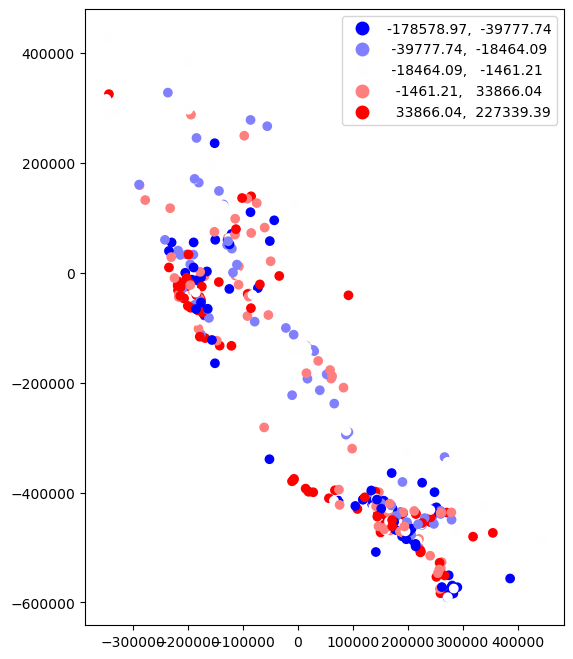

In [43]:
# Global Spatial Autocorrelation
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [44]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=7) 
wi.transform = 'r'
y = test_p['test_res']

In [45]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.071 and p-value is 0.002997002997002997 expected value is -0.0024390243902439024


In [46]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [47]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
#test_p.head(2)

group
not-significant    352
hotspot             21
coldspot            20
hot outlier         10
cold outlier         8
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_17604\3423496464.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'


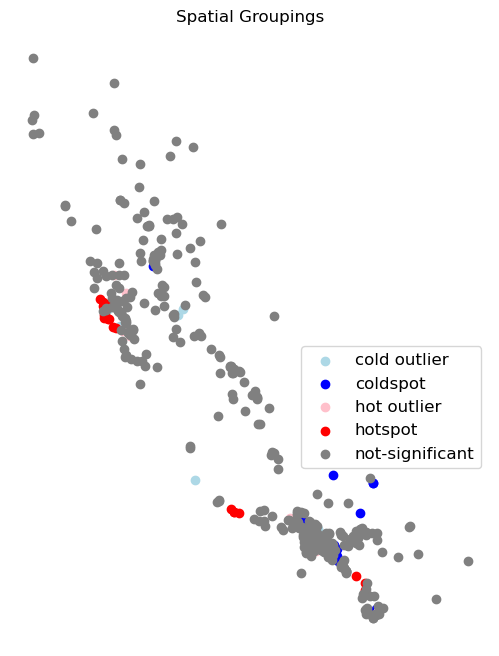

In [48]:
# Vizualize spatial groupings and significance
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in test_p.groupby('group'):
    
    color = group_colors[ctype]
    
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()

## Runtime

In [49]:
print("Time for whole script: {:.2f} seconds".format(time() - start_time))

Time for whole script: 39.28 seconds
